<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Departamento de Datos no Estructurados  </h1>


<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problmeas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información.
</p>


**Nota** <br>
Tenga en cuneta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habiliadades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

## Clasificación de Imágenes

##0. Librerías y dependencias

Para garantizar el correcto funcionamiento de los desarrollos realizados en el presente Notebook, es requerida la instalación de las siguientes librerías:

In [ ]:
from google.colab import drive
import zipfile
import os
from numbers import Number
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import os
import zipfile
from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
from PIL import Image
from collections import Counter
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
from IPython.display import Image, display

Adicionalmente, se confirman las dependencias extras que se pueden tener con sus respectivas versiones:

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

### 1.Importe las imágenes
Para realizar la carga de los documentos dentro del Notebook, primero se realiza la carga de los archivos *Blanco.zip* y *Documento.zip* a Google Drive, posteriormente se realiza una conexión a este repositorio

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.1 Archivos en Blanco

Se procede a la copia del archivo *Blanco.zip* dentro de la carpeta Documentos en el Notebook, adicionalmente se realiza el descomprimido de la misma.

In [ ]:
ruta_zip = '/content/drive/MyDrive/Prueba ADNE/Imagenes/Blanco.zip' #Ruta Drive
carpeta_destino = '/content/Documentos' #Ruta Destino en Colab

os.makedirs(carpeta_destino, exist_ok=True)

# Extraer el contenido del archivo .zip
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

Con el fin de validar las imágenes cargadas, se visualizarán 4 de ellas:

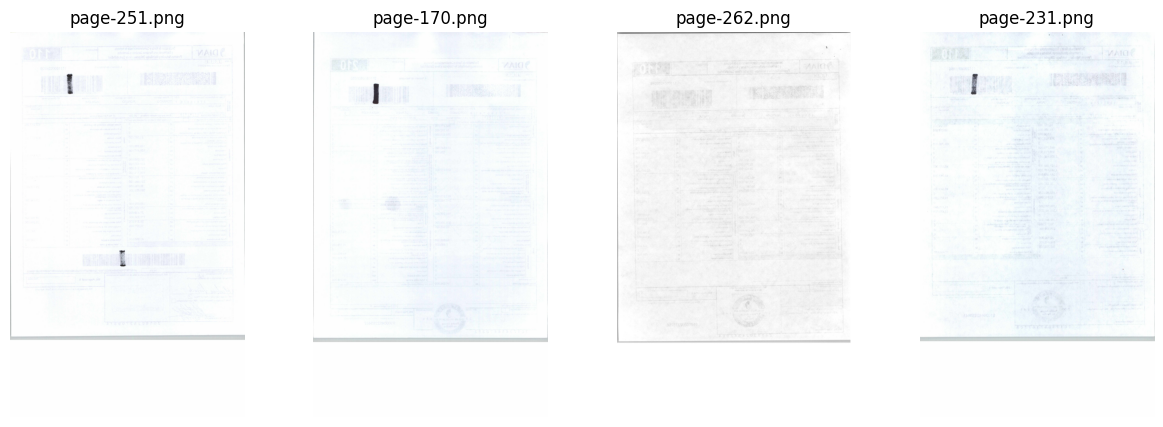

In [ ]:
Ruta_blancos="/content/Documentos/Blanco"
imag_muestra=os.listdir(Ruta_blancos)[22:26]

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
cont=0

for img in imag_muestra:
    ruta=os.path.join(Ruta_blancos, img)

    imagen = mpimg.imread(ruta)
    axs[cont].imshow(imagen)
    axs[cont].axis('off')
    axs[cont].set_title(img)
    cont=cont+1

Adicionalmente, se confirma que se cuenta con 147 imágenes en blanco para trabajar

In [ ]:
len(os.listdir(Ruta_blancos))

147

##1.2 Archivos con información

Homologo al caso de las imágenes en blanco, se procede a la copia del archivo *Documento.zip* dentro de la carpeta Documentos en el Notebook, adicionalmente se realiza el descomprimido de la misma.

In [ ]:
ruta_zip = '/content/drive/MyDrive/Prueba ADNE/Imagenes/Documento.zip'
carpeta_destino = '/content/Documentos'

os.makedirs(carpeta_destino, exist_ok=True)

# Extraer el contenido del archivo .zip
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

Nuevamente, se muestran 4 ejemplos de las imágenes cargadas.

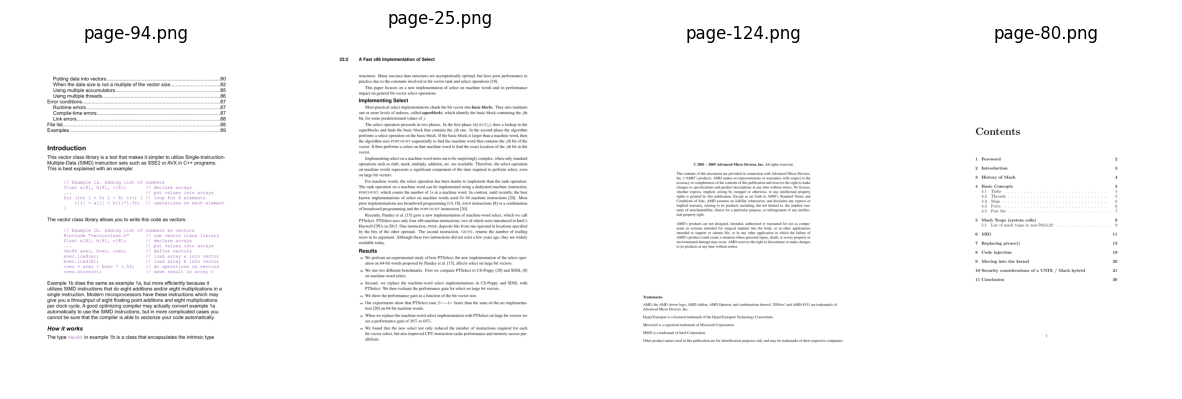

In [ ]:
Ruta_documento="/content/Documentos/Documento"
imag_muestra=os.listdir(Ruta_documento)[0:4]

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
cont=0

for img in imag_muestra:
    ruta=os.path.join(Ruta_documento, img)

    imagen = mpimg.imread(ruta)
    axs[cont].imshow(imagen)
    axs[cont].axis('off')
    axs[cont].set_title(img)
    cont=cont+1

Adicionalmente, se confirma que se cuenta con 100 imágenes que contienen información para trabajar.

In [ ]:
len(os.listdir(Ruta_documento))

100

### 2. Estructure la información

Una vez cargado y analizado el contenido de nuestro conjunto de datos, se procederá a la transformación del mismo, de manera que permita la posterior ejecución de los modelos propuestos. Teniendo en cuenta que este proyecto busca realizar la clasificación de imágenes, se hará uso de redes convolucionales, las cuales tienen un mejor desempeño para este tipo de información insumo.

Adicionalmente, para lograr el mejor resultado del modelo y considerando que las imágenes pueden tener diferentes tamaños, se realizará un escalado de cada imagen para dejarlas en tensores de dimensión *(224,224,3)*, donde se manejarán 3 canales, ya que todas las imágenes presentes en el conjunto de datos son a color.

Finalmente, para la etapa de modelado, requerimos que la información se encuentre separada por datos de entrenamiento, validación y prueba, lo cual se procede a ejecutar para las imágenes en blanco y con información

Se procede a la transformación de las imágenes en Blanco:

In [ ]:
img_blanco = []

for im_path in os.listdir(Ruta_blancos):
    img_blanco.append(np.array(tf.keras.preprocessing.image.load_img(Ruta_blancos+"/"+im_path,
                                                                         target_size=(224, 224, 3))))

X_Blanco = np.array(img_blanco)
Y_Blanco = np.full(len(X_Blanco),0)

Se procede a la transformación de las imágenes con información:

In [ ]:
img_informacion= []

for im_path in os.listdir(Ruta_documento):
    img_informacion.append(np.array(tf.keras.preprocessing.image.load_img(Ruta_documento+"/"+im_path,
                                                                         target_size=(224, 224, 3))))

X_informacion = np.array(img_informacion)
Y_informacion = np.full(len(X_informacion),1)

Una vez transformada la información, se procede a la unión de la información transformada y las etiquetas:

In [ ]:
X= np.concatenate((X_Blanco, X_informacion), axis=0)
Y= np.concatenate((Y_Blanco, Y_informacion), axis=0)

print( f" Tamaño del Tensor de X {X.shape}"  )
print( f" Tamaño del Tensor de Y {Y.shape}"  )

 Tamaño del Tensor de X (247, 224, 224, 3)
 Tamaño del Tensor de Y (247,)


Para proceder con el entrenamiento del modelo, se realiza la separación del conjunto de datos los conjuntos de entrenamiento(*X_train* y *y_train*), validación (*X_val* y *y_val*) y pruebas (*X_test* y *y_test*), teniendo una distribución sobre el total de información del 60%, 20% y 20% respectivamente. Dicha distribución se realiza teniendo en cuenta la proporción de cada categoría en la variable respuesta.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Verifiquemos los tamaños para cada conjunto:

In [ ]:
print( f" Tamaño del conjunto X_train {X_train.shape} "  )
print( f" Tamaño del conjunto X_val {X_val.shape} "  )
print( f" Tamaño del conjunto X_test {X_test.shape} "  )

print( f"\n Tamaño del conjunto y_train {y_train.shape} "  )
print( f" Tamaño del conjunto y_val {y_val.shape} "  )
print( f" Tamaño del conjunto y_test {y_test.shape} "  )


 Tamaño del conjunto X_train (148, 224, 224, 3) 
 Tamaño del conjunto X_val (49, 224, 224, 3) 
 Tamaño del conjunto X_test (50, 224, 224, 3) 

 Tamaño del conjunto y_train (148,) 
 Tamaño del conjunto y_val (49,) 
 Tamaño del conjunto y_test (50,) 


### 3. Describa su Estrategia de Análisis


Como se mencionó anteriormente, teniendo en cuenta el objetivo es lograr la clasificación de imágenes se utilizara una red neuronal convolucional, dado que es la más indicada para este tipo de data, adicionalmente, teniendo en cuenta que tenemos poca información en el conjunto de entrenamiento (247 imágenes) y las redes convolucionales requiere de gran cantidad de información para su correcto entrenamiento, se propone utilizar la técnica de Data Augmentation.  

La técnica de Data Augmentation nos permite generar nuevas imágenes transformadas a partir del conjunto inicial, para este alcance se tendran en cuenta las siguientes transformaciones en el conjunto de entrenamiento:

- **rotation_range**: Realiza rotaciones de las imágenes.
- **width_shift_range**: Genera traslaciones horizontales de las imágenes.
- **height_shift_range**: Genera traslaciones verticales de las imágenes.
- **shear_range**: Generará el efecto de cizallamiento o shear.
- **zoom_range**: Generá el efecto de aumento o zoom.
- **horizontal_flip**: Se especifica si las imágenes generadas se pueden invertir horizontalmente.
- **fill_mode**: En algunas transformaciones aparecen espacios que no estaban contenidos en la imagen original, este parámetro permite especificar si estos espacios se llenarán con el pixel más cercano "nearest" o con un valor constante "constant".
- **rescale**: Realiza el reescalado de la imágen.

In [ ]:
train_datagen_1 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant'
)

train_gen_1 = train_datagen_1.flow(x=X_train,
                               y=y_train,
                               batch_size=32)


Se genera un Data Augmentation para el conjunto de validación, pero únicamente cambiando el reescalado de la imagen original

In [ ]:
valid_datagen_1 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_gen_1 = valid_datagen_1.flow(x=X_val,
                               y=y_val,
                               batch_size=32)

Verificamos 9 imágenes de prueba construidas a partir del Data Augmentation con información del conjunto de entrenamiento.

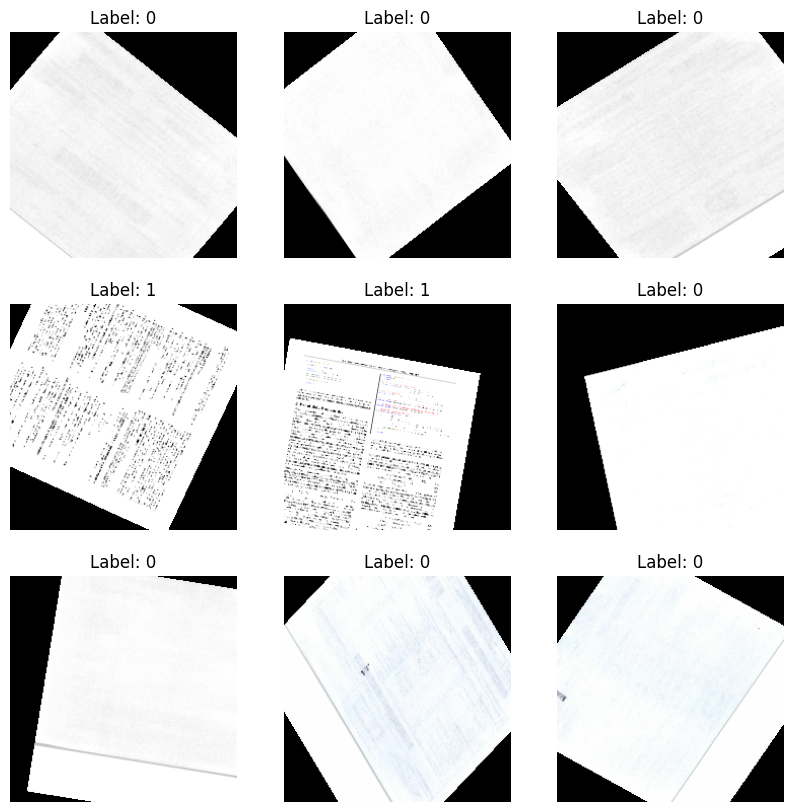

In [ ]:
ims, lab = next(train_gen_1)

plt.figure(figsize=(10, 10))

# Mostramos 9 ejemplos
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(ims[i]); plt.axis("off"); plt.title(f"Label: {lab[i]}")


Una vez realizado el data augmentation, se procede con la selección y diseño del modelo. Se realiza el entrenamiento de una red neuronal convolucional con las siguientes especificaciones:

- Capa de entrada con las dimensiones de los tensores de entrenamiento.
- 5 Bloques con capas convolucionales con función de activación *relu* y capas de pooling. Para las capas convolucionales se irá aumentando el número de filtros conforme avancen los bloques, y se reducirán los tamaños del kernel utilizados, referente a las capas de pooling se manejará el mismo tamaño en todos los bloques.
- Capa Flatten para reducir la dimensión de la salida.
- 2 capas densas de 256 y 512 neuronas con función de activación *relu*.
- Capa de regularización con un dropout de 0.2.
- Capa de salida con 1 neurona con función de activación *sigmoid* teniendo en cuenta que es una clasificación binaria.


In [ ]:
#Definimos el modelo en keras
conv_net = tf.keras.models.Sequential()

#Capa de entrada
width  =X_train.shape[1]
height  =X_train.shape[2]

conv_net.add(tf.keras.layers.Input(shape=(width, height, 3)))

#Primer bloque
conv_net.add(tf.keras.layers.Conv2D(
    filters = 8, kernel_size = 5, activation = 'relu'
))
conv_net.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

#Segundo bloque
conv_net.add(tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = 4,
    activation = 'relu'
))
conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

#Tercer bloque
conv_net.add(tf.keras.layers.Conv2D(
    filters = 32,
    kernel_size = 3,
    activation = 'relu'
))
conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

#Cuarto bloque
conv_net.add(tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = 2,
    activation = 'relu'
))
conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

#Quinto bloque
conv_net.add(tf.keras.layers.Conv2D(
    filters = 128,
    kernel_size = 2,
    activation = 'relu'
))
conv_net.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

#capa flatten, que transforma cualquier arreglo multidimensional en un vector unidimensional.
conv_net.add(tf.keras.layers.Flatten())

#####Clasificador
# Capa densa intermedia
conv_net.add(tf.keras.layers.Dense(units=256, activation='relu'))

# Capa densa intermedia
conv_net.add(tf.keras.layers.Dense(units=512, activation='relu'))

# Agregamos dropout para regularización
conv_net.add(tf.keras.layers.Dropout(0.2))

# Capa de salida
conv_net.add(tf.keras.layers.Dense(units=1, #Número de categorías
                                   activation='sigmoid')) #Clasificación binaria

La arquitectura del modelo queda de la siguiente manera:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 16)      2064      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 51, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 25, 25, 32)       

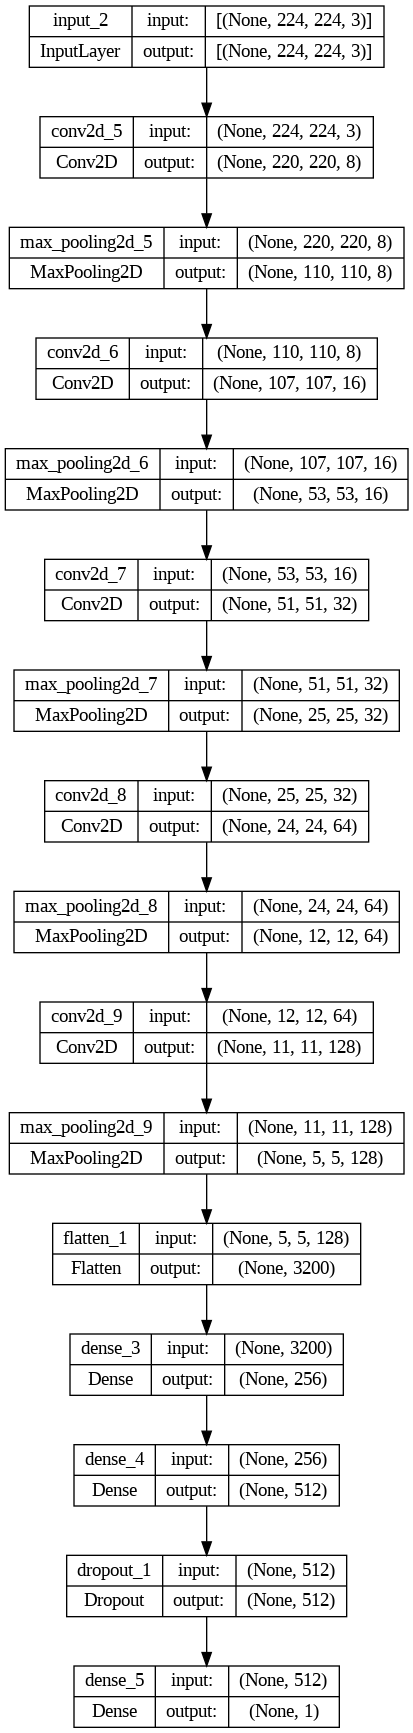

In [ ]:
conv_net.summary()
tf.keras.utils.plot_model(conv_net,show_shapes=True)

Se realiza la compilación del modelo, donde como función de perdida se utilizará *binary_crossentropy* teniendo en cuenta que es una clasificación binaria, con un optimizador Adam.

In [ ]:
conv_net.compile(loss='binary_crossentropy', #Función de perdida para clasificación binaria
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics = ["accuracy"])

Se define un checkpoint que permite guardar los mejores pesos del entrenamiento para poder usarlos posteriormente. Adicionalmente, definimos un criterio de parada para evitar el sobreajuste del modelo, este con una paciencia de 10 épocas. Finalmente, entrenamos el modelo.

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                  filepath='best_weights.h5',
                  monitor="val_loss",
                  mode="min",
                  save_best_only=True,
                  save_weights_only=True
              )

stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                mode="min",
                restore_best_weights=True
            )


total_samples = X_train.shape[0]
validation_samples= X_val.shape[0]
batch_size = 32

# Entrenamos el modelo
history = conv_net.fit(train_gen_1,
                       steps_per_epoch=total_samples // batch_size,
                       epochs=50,
                       validation_data= valid_gen_1 ,
                       callbacks=[checkpoint, stopping] )

Epoch 1/50
4/4 [==============================] - 8s 1s/step - loss: 0.7257 - accuracy: 0.4655 - val_loss: 0.6899 - val_accuracy: 0.4082
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 0.6867 - accuracy: 0.5431 - val_loss: 0.6915 - val_accuracy: 0.5918
Epoch 3/50
4/4 [==============================] - 6s 2s/step - loss: 0.6691 - accuracy: 0.6121 - val_loss: 0.6511 - val_accuracy: 0.5918
Epoch 4/50
4/4 [==============================] - 6s 2s/step - loss: 0.6366 - accuracy: 0.6724 - val_loss: 0.5614 - val_accuracy: 0.9796
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.5579 - accuracy: 0.7931 - val_loss: 0.4654 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 6s 1s/step - loss: 0.3888 - accuracy: 0.8966 - val_loss: 0.1929 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 0.1755 - accuracy: 0.9569 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 8/50
4/4 [=========================

Para cada uno de los entrenamientos del modelo, se han guardado las métricas de Loss y Accuracy para los conjuntos de entrenamiento y validación, para poder visualizar de mejor manera dicha información a continuación se presenta un gráfico del comportamiento de las métricas.

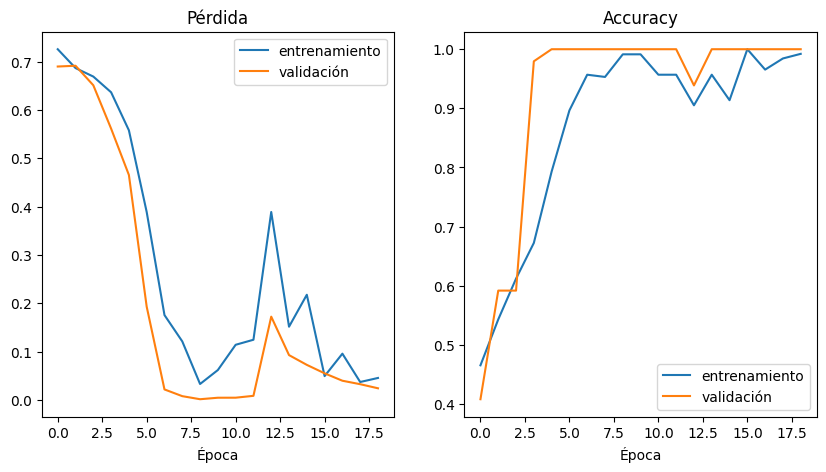

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history["loss"], label="entrenamiento")
plt.plot(history.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(history.history["accuracy"], label="entrenamiento")
plt.plot(history.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

Se observa que el modelo rápidamente logra tener un buen ajuste, ya que aproximadamente para el sexto Epoch ya se logra un accuracy cercado a 1 para los conjuntos de validación y entrenamiento, teniendo en cuenta el buen desempeño en el entrenamiento se toma el mejor modelo guardado en *best_weights.h5*

### 4. Evaluación del modelo


Obteniendo el modelo ganador, se procede a realizar la clasificación de las imágenes de prueba, con el fin de poder medir el comportamiento del modelo en imágenes que nunca ha visto.

Se crea la matriz de confusión donde se realiza la comparación de las categorías reales de las imágenes con las estimadas por el modelo, obteniendo que el 100% de las imágenes de prueba son clasificadas correctamente, por lo cual podemos determinar que el modelo es idóneo para su uso.

2/2 [==============================] - 1s 286ms/step


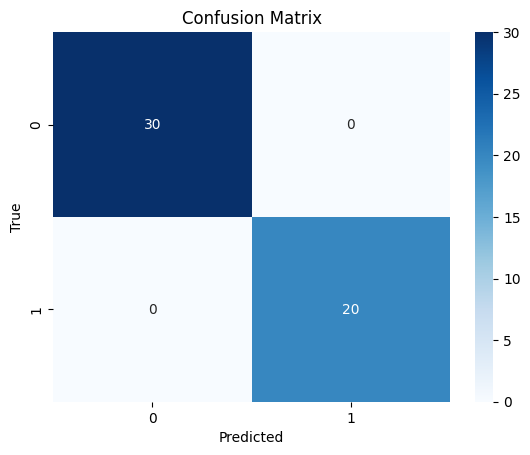

In [ ]:
y_pred = conv_net.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Adicionalmente, para evaluar el desempeño del modelo, se realiza el calculo de las métricas de *precisión*, *recall*, *f1-score* y *accuracy* sobre las estimaciones del modelo en el conjunto de pruebas comparado con las etiquetas originales, obteniendo un resultado de clasificación perfecta.

In [ ]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación como un dataframe
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,30.0
1,1.0,1.0,1.0,20.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,50.0
weighted avg,1.0,1.0,1.0,50.0


##5. Implementación Colab

Con el proceso desarrollado anteriormente es posible identificar si la imágen contiene información, sin embargo, la idea es generar un proceso que además de realizar dicha identificación, pueda mover los archivos a su carpeta correspondiente. Para este fin primero vamos a crear la carpeta *Prueba_Clasifica* en donde se cargarán todas las imágenes para su posterior clasificación y movimiento.

In [ ]:
carpeta_destino = '/content/Prueba_Clasifica' #Ruta Destino en Colab
os.makedirs(carpeta_destino, exist_ok=True)

!cp -r /content/Documentos/Blanco/* /content/Prueba_Clasifica
!cp -r /content/Documentos/Documento/* /content/Prueba_Clasifica


Una vez cargadas las imagenes, se procede a realizar la vectorización de las mismas, tal como se hizo en la fase de entrenamiento.

In [ ]:
img_clasifica = []
rutas= []
for im_path in os.listdir(carpeta_destino):
    img_clasifica.append(np.array(tf.keras.preprocessing.image.load_img(carpeta_destino+"/"+im_path,
                                                                         target_size=(224, 224, 3))))
    rutas.append(carpeta_destino+"/"+im_path)

X_clasifica = np.array(img_clasifica)
X_clasifica.shape

(247, 224, 224, 3)

Con las imágenes vectorizadas, se procede a realizar la predicción de la clase perteneciente con el modelo entrenado.

In [ ]:
y_clasifica = conv_net.predict(X_clasifica)
y_clasifica = y_clasifica.flatten().tolist()

8/8 [==============================] - 5s 617ms/step


Se genera un DataFrame con la ruta de cada imagen y su respectiva categoría estimada.

In [ ]:
data= {
    'Ruta':rutas,
    'Categoria':y_clasifica
}
Resultados = pd.DataFrame(data)
Resultados['Categoria'] = Resultados['Categoria'].round()

Resultados.head()

,Ruta,Categoria
0,/content/Prueba_Clasifica/page-195.png,0.0
1,/content/Prueba_Clasifica/page-241.png,0.0
2,/content/Prueba_Clasifica/page-175.png,0.0
3,/content/Prueba_Clasifica/page-212.png,0.0
4,/content/Prueba_Clasifica/page-94.png,1.0


Se verifica la cantidad de imágenes categorizadas como sin información (0) y con información (1), observando que se tiene la misma cantidad en cada categoría que la distribución original, mostrando el buen desempeño del modelo.

In [ ]:
Resultados.Categoria.value_counts()

Categoria
0.0    147
1.0    100
Name: count, dtype: int64

Finalmente, se crean las carpetas *docs_con_contenido* y *docs_sin_contenido*, donde se alojarán las imágenes clasificadas. Posteriormente se ejecuta el movimiento de las mismas.

In [ ]:
os.makedirs('/content/docs_con_contenido', exist_ok=True)
os.makedirs('/content/docs_sin_contenido', exist_ok=True)


In [ ]:
len=Resultados.shape[0]

prueba=Resultados.Ruta[0]
prueba_catego=Resultados.Categoria[0]

for i in range(len):
    if Resultados.Categoria[i]==0:
        shutil.move(Resultados.Ruta[i], '/content/docs_sin_contenido')
    elif  Resultados.Categoria[i]==1:
        shutil.move(Resultados.Ruta[i], '/content/docs_con_contenido')


Se observa el contenido de la carpeta *docs_sin_contenido*

In [ ]:
!ls '/content/docs_sin_contenido'

page-156.png  page-177.png  page-198.png  page-219.png	page-240.png  page-261.png  page-282.png
page-157.png  page-178.png  page-199.png  page-220.png	page-241.png  page-262.png  page-283.png
page-158.png  page-179.png  page-200.png  page-221.png	page-242.png  page-263.png  page-284.png
page-159.png  page-180.png  page-201.png  page-222.png	page-243.png  page-264.png  page-285.png
page-160.png  page-181.png  page-202.png  page-223.png	page-244.png  page-265.png  page-286.png
page-161.png  page-182.png  page-203.png  page-224.png	page-245.png  page-266.png  page-287.png
page-162.png  page-183.png  page-204.png  page-225.png	page-246.png  page-267.png  page-288.png
page-163.png  page-184.png  page-205.png  page-226.png	page-247.png  page-268.png  page-289.png
page-164.png  page-185.png  page-206.png  page-227.png	page-248.png  page-269.png  page-290.png
page-165.png  page-186.png  page-207.png  page-228.png	page-249.png  page-270.png  page-291.png
page-166.png  page-187.png  page-208.png

Se observa el contenido de la carpeta *docs_con_contenido*

In [ ]:
!ls '/content/docs_con_contenido'

page-107.png  page-123.png  page-148.png  page-31.png  page-48.png  page-65.png  page-84.png
page-109.png  page-124.png  page-149.png  page-32.png  page-49.png  page-66.png  page-85.png
page-10.png   page-12.png   page-150.png  page-34.png  page-4.png   page-67.png  page-87.png
page-112.png  page-134.png  page-155.png  page-35.png  page-50.png  page-68.png  page-88.png
page-113.png  page-135.png  page-15.png   page-36.png  page-51.png  page-6.png	 page-89.png
page-114.png  page-136.png  page-16.png   page-37.png  page-52.png  page-72.png  page-8.png
page-115.png  page-137.png  page-18.png   page-39.png  page-53.png  page-73.png  page-92.png
page-116.png  page-138.png  page-19.png   page-3.png   page-55.png  page-74.png  page-93.png
page-117.png  page-139.png  page-23.png   page-41.png  page-57.png  page-75.png  page-94.png
page-118.png  page-13.png   page-24.png   page-42.png  page-59.png  page-77.png  page-9.png
page-119.png  page-140.png  page-25.png   page-43.png  page-60.png  page-

Finalmente, se confirma que con este proceso es posible clasificar y mover un lote de imagenes en sus carpetas destino, de requerirse la replicación en otro notebook, se debe garantizar que se cargue el modelo y sean actualizadas las rutas iniciales y de destino.

##6. Implementación transversal.

En la presente sección se da una arquitectura de referencia en la implementación del caso de uso si se requiere una automatización más transversal. Es importante aclarar que la arquitectura puede variar dependiendo las volumetrías utilizadas y la naturaleza del proceso. Sin pérdida de generalidad, se propone una arquitectura en GCP, sin embargo, la solución puede ser implementada en cualquier nube, únicamente se deberán homologar los servicios a utilizar.

## 6.1 Arquitectura Batch

La arquitectura propuesta para la implementación del servicio en Batch es:

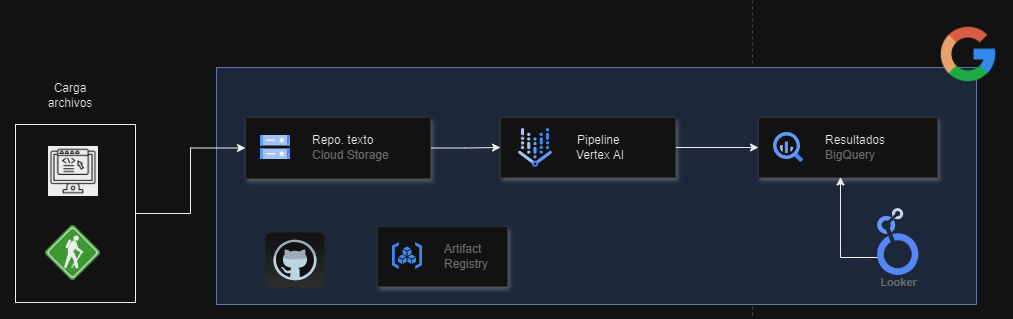

In [ ]:
display(Image("Batch.png", height=400))

- **Cloud Storage**: Repositorio en donde se deben alojar las imágenes sujetas al análisis, así como su clasificación final en la carpeta correspondiente.
- **Vertex AI**: Servicio que contendrá toda la lógica desarrollada para la clasificación de la imagen, incluyendo la ejecución del modelo y la distribución en carpetas.
- **BigQuery**: Repositorio en donde se dejará la metadata de las imágenes, así como el resultado del modelo.
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- La carga de los documentos dependerá de la naturaleza del caso de uso a implementar, si se requiere únicamente la disponibilización del modelo para su uso, se recomiendo el uso de un front, por otro lado, si lo que se requiere es un proceso automático masivo, se recomiendan herramientas tipo go anywhere para el cargue de la información.

## 6.2 Arquitectura Real time

Referente a la implementación del proceso en Real time se propone el uso de la siguiente arquitectura.

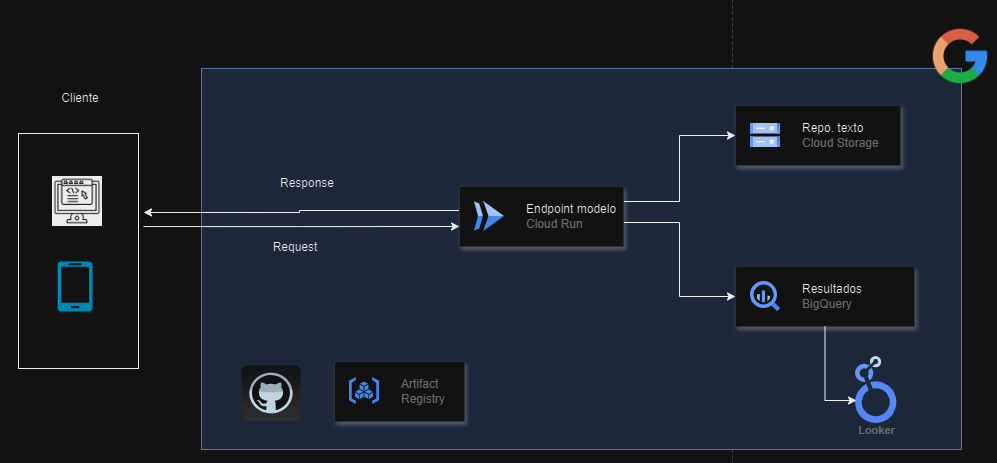

In [ ]:
display(Image("Real Time.png", height=500))

- **Cloud Storage**: Repositorio en donde se deben alojar las imágenes analizadas y clasificadas.  
- **Cloud RUN**: Servicio que contendrá toda la lógica desarrollada para la clasificación de la imagen, incluyendo la ejecución del modelo y la distribución en carpetas.
- **BigQuery**: Repositorio en donde se dejará la metadata de las imágenes, así como el resultado del modelo.
- **Looker**: Servicio que permite la visualización de los resultados de una forma interactiva.
- **GitHub**: Repositorio de código donde también se ejecutarán pruebas unitarias y de vulnerabilidad del código desarrollado.
- **Artifact Registry**: Servicio donde se diponibilizará la imagen creada con el código alojado en GitHub, y será disponibilizada en la instancia de ejecución.
- Al disponibilizar el desarrollo como un api, se garantiza que pueda ser llamado por cualquier aplicativo, incluyendo apps de celulares o un front de atención.

Adicionalmente, para la exposición del API se deben considerar los lineamientos dados por el equipo de seguridad, con el fin de determinar el camino más adecuado y seguro de implementación, en donde se considerará quien será el cliente final que consumirá dicha API.


##7. Conclusiones

Con el objetivo de poder identificar imágenes con y sin información, se ha entrenado una red neuronal convolucional que logra determinar si una imagen tiene contenido y posteriormente la clasifica en diferentes carpetas. Dicho modelo tiene una asertividad del 100%, sin embargo, es importante poder realizar el respectivo monitoreo del modelo, para garantizar que las métricas del modelo se mantenga, en caso de un deterioro, se recomienda la intervención del modelo, generando un reentrenamiento con nueva información.

Este desarrollo da alcance al objetivo de clasificar las imágenes, sin embargo, se realiza de una manera operativa, dado que se requiere modificar las rutas iniciales y finales, asi como ejecutar manualmente el notebook, por lo que se recomienda automatizar el proceso en una de las arquitecturas planteadas, en caso de que la ejecución de la clasificación sea una tarea recurrente.
